In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import timeit

In [2]:
def get_pairwise_distances(R):
    dists = np.stack([
        np.abs(R[:, 0].reshape(-1, 1) - R[:, 0].reshape(1, -1)),
        np.abs(R[:, 1].reshape(-1, 1) - R[:, 1].reshape(1, -1))
    ])
    dists = np.sqrt(np.sum(dists ** 2, axis=0))
    return dists

In [69]:
N = 150  # number of nodes in graph
M = 100  # number of ants
h_len = 50  # history length

In [70]:
lattice = np.random.uniform(low=0, high=1, size=[N, 2])
degree = np.minimum(np.abs(np.random.standard_cauchy(size=[N])) + 1, np.sqrt(N)).astype(np.int32)

source = np.argmin(np.sum(lattice ** 2, axis=-1)).astype(np.int32)
sink = np.argmax(np.sum(lattice ** 2, axis=-1)).astype(np.int32)

In [71]:
dists_idx = np.argsort(get_pairwise_distances(lattice), axis=-1)
edges = [(i, dists_idx[i, np.unique(np.minimum(
    np.cumsum(np.minimum(np.abs(np.random.standard_cauchy(size=[N])) + 1, min(np.sqrt(N), N)).astype(np.int32)),
    int(min(3 * np.sqrt(N), N)))
)[:d]]) for i, d in enumerate(degree)]
edges = [[(i, j) for j in sinks] + [(j, i) for j in sinks] for i, sinks in edges]

while len(edges) > 1:
    edges[-1] += edges.pop(0)

edges = sorted(list(set(edges[0])))
row, col = np.array(edges).T.tolist()

In [72]:
adj = np.zeros([N, N])
np.add.at(adj, (row, col), 1)

adj_n = adj
shortest_path_len = None

for i in range(N):
    adj_n = adj_n @ adj
    if adj_n[source, sink] > 0:
        shortest_path_len = i + 1
        break

print(shortest_path_len)
assert shortest_path_len, "Source and sink in different components"

8


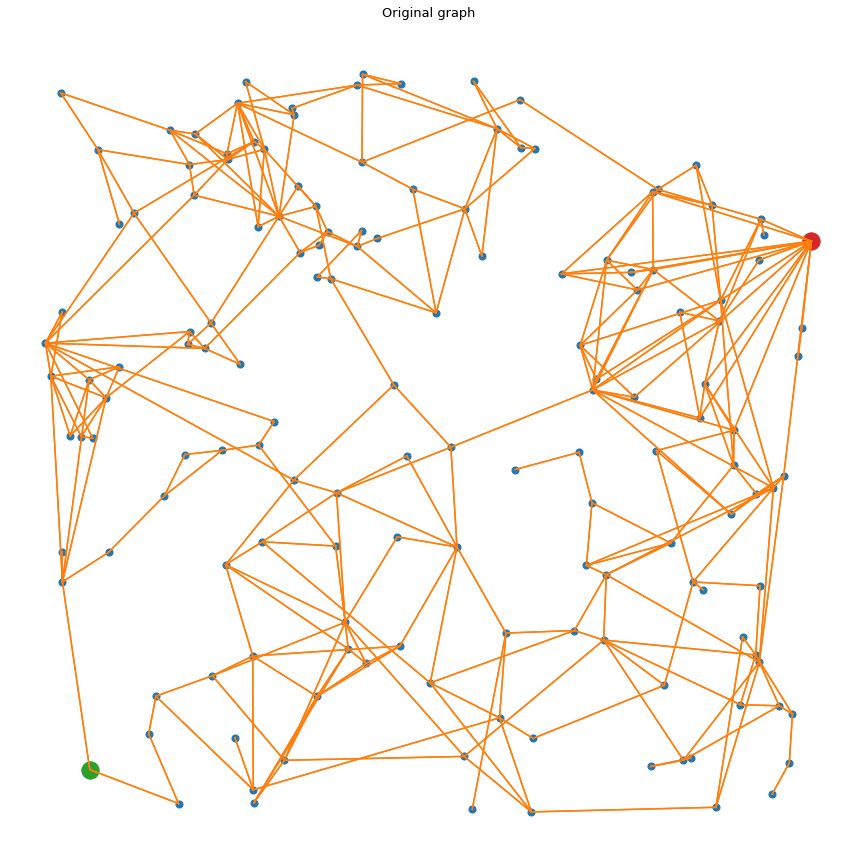

In [73]:
points = lattice

plt.figure(figsize=(12, 12))

plt.title("Original graph\n", fontsize=13)
for i, point in enumerate(points):
    s = 300 if i in [source, sink] else 50
    c = ('tab:green' if i == source else 'tab:red') if i in [source, sink] else 'tab:blue'
    plt.scatter(point[0], point[1], c=c, s=s)

for i, j in zip(row, col):
    plt.plot([points[i][0], points[j][0]], [points[i][1], points[j][1]], c='tab:orange')

plt.axis('off')
plt.tight_layout()
plt.show()

In [74]:
row_tensor = tf.constant(row, dtype=tf.int32)
col_tensor = tf.constant(col, dtype=tf.int32)
hashes = N * row_tensor + col_tensor

In [75]:
tau = 1.0 / tf.cast(tf.gather(tf.math.segment_sum(tf.ones_like(row_tensor), row_tensor), row_tensor), tf.float32)
eta = tf.ones_like(row_tensor, dtype=tf.float32)

proba = tau * eta
proba = proba / tf.gather(tf.math.segment_sum(proba, row_tensor), row_tensor)

threshold = tf.math.cumsum(proba) - tf.cast(row_tensor, dtype=tf.float32)

In [76]:
@tf.function(reduce_retracing=True, jit_compile=False)
def traverse_one_step(row, col, ants, threshold, epoch, s_mod=1):
    thresholds_per_agent = tf.gather(
        tf.where(row == tf.reshape(tf.range(N, dtype=tf.int32), [-1, 1]), threshold, 0),
        indices=ants)

    targets = tf.gather(
        col,
        tf.argmax((thresholds_per_agent - tf.random.stateless_uniform([M], seed=[epoch, -s_mod * epoch])[:, tf.newaxis]) > 0, axis=-1))

    return targets


@tf.function(reduce_retracing=True, jit_compile=False)
def proceed_one_epoch(row, col, hashes, ants, history, proba, starts, end, sink, source, h_len, N, M, epoch, s_mod):
    threshold = tf.math.cumsum(proba) - tf.cast(row, dtype=tf.float32)
    ants = traverse_one_step(row, col, ants, threshold, epoch=epoch, s_mod=s_mod)
    history = tf.tensor_scatter_nd_update(history, tf.transpose(tf.stack([tf.fill([M], end), tf.range(M)])), ants)

    is_at_target = tf.boolean_mask(tf.range(M), ants == sink)
    t = tf.tile(tf.gather(history, is_at_target, axis=-1), [2, 1])[:h_len + end + 1]
    s = tf.gather(tf.where(starts > end, starts, starts + h_len), is_at_target)

    history = tf.tensor_scatter_nd_update(
        history, tf.transpose(tf.stack([tf.fill([M], end), tf.range(M)])), tf.where(ants == sink, source, ants))

    starts = tf.where(ants == sink, end, starts)
    starts = tf.where(ants == source, end, starts)
    ants = tf.where(ants == sink, source, ants)

    edges_to_enhance = tf.boolean_mask(
        tf.reshape(tf.transpose(tf.stack([t[:-1, :], t[1:, :]], axis=-1), [1, 0, 2]), [-1, 2]),
        tf.reshape(tf.transpose((tf.cumsum(tf.ones_like(t), axis=0) - 1)[1:, :] > s), [-1])
    )

    hashed_selected_edges = N * edges_to_enhance[:, 0] + edges_to_enhance[:, 1]
    updates = tf.reduce_sum(tf.cast(tf.reshape(hashed_selected_edges, [-1, 1]) == hashes, dtype=tf.int32), axis=0)

    proba *= tf.pow(1.1, tf.cast(updates, dtype=tf.float32))
    proba = tf.maximum(proba, 0.05 * eta)
    proba = proba / tf.gather(
        tf.math.reduce_sum(
            tf.cast(row == tf.reshape(tf.range(N), [-1, 1]), dtype=tf.float32) * proba[tf.newaxis, :], axis=-1),
        row)
    
    return proba, ants, history, starts, tf.reduce_sum(tf.ones_like(s))

# Without XLA compilation

In [77]:
@tf.function(reduce_retracing=True, jit_compile=False)
def gpu_run(row, col, hashes, tau, epochs, N=N, M=M, s_mod=1):
    with tf.GradientTape() as t:
        with t.stop_recording():
            ants = tf.zeros([M], dtype=tf.int32)
            starts = tf.zeros_like(ants, dtype=tf.int32)
            stats = tf.zeros([epochs], dtype=tf.int32)

            history = tf.zeros([h_len, M], dtype=tf.int32)
            history = tf.tensor_scatter_nd_update(history, tf.transpose(tf.stack([tf.fill([M], 0), tf.range(M)])), ants)

            eta = tf.ones_like(row, dtype=tf.float32)

            proba = tau * eta
            proba = proba / tf.gather(
                tf.math.reduce_sum(
                    tf.cast(row == tf.reshape(tf.range(N), [-1, 1]), dtype=tf.float32) * proba[tf.newaxis, :], axis=-1),
                row)

            step = tf.constant(0, dtype=tf.int32)
            while tf.less(step, epochs):
                proba, ants, history, starts, s = proceed_one_epoch(row, col, hashes, ants, history, proba, starts, step % h_len, sink, source, h_len, N, M, step, s_mod)
                stats = tf.tensor_scatter_nd_update(stats, [[step]], [s])
                step += 1
            
            return proba, stats

In [78]:
start_time = timeit.default_timer()

with tf.device('cpu:0'):
    proba, stats = gpu_run(row_tensor, col_tensor, hashes, tau, epochs=2500, s_mod=5)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

Time 4.6830s


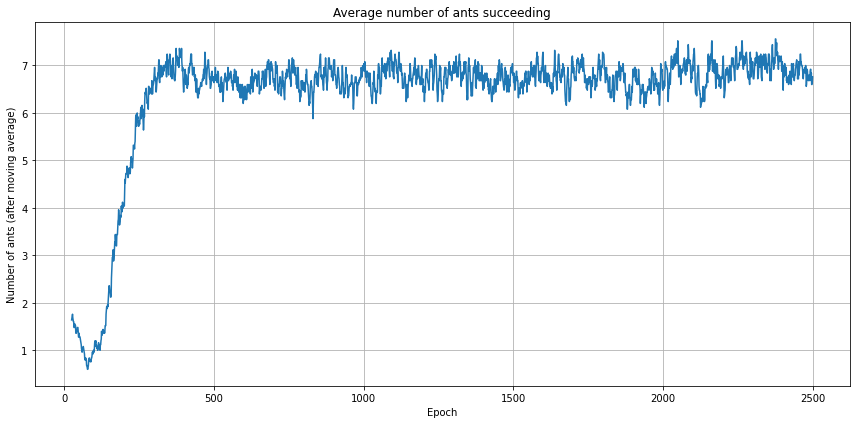

In [79]:
plt.figure(figsize=(12, 6))

ma = 25
cumusum = np.cumsum(stats)
avg_number_of_successful_ants = (cumusum[ma:] - cumusum[:-ma]) / ma
plt.title("Average number of ants succeeding")
plt.xlabel("Epoch")
plt.ylabel("Number of ants (after moving average)")
plt.plot(np.arange(ma, len(stats)), avg_number_of_successful_ants)
plt.grid()
plt.tight_layout()
plt.show()

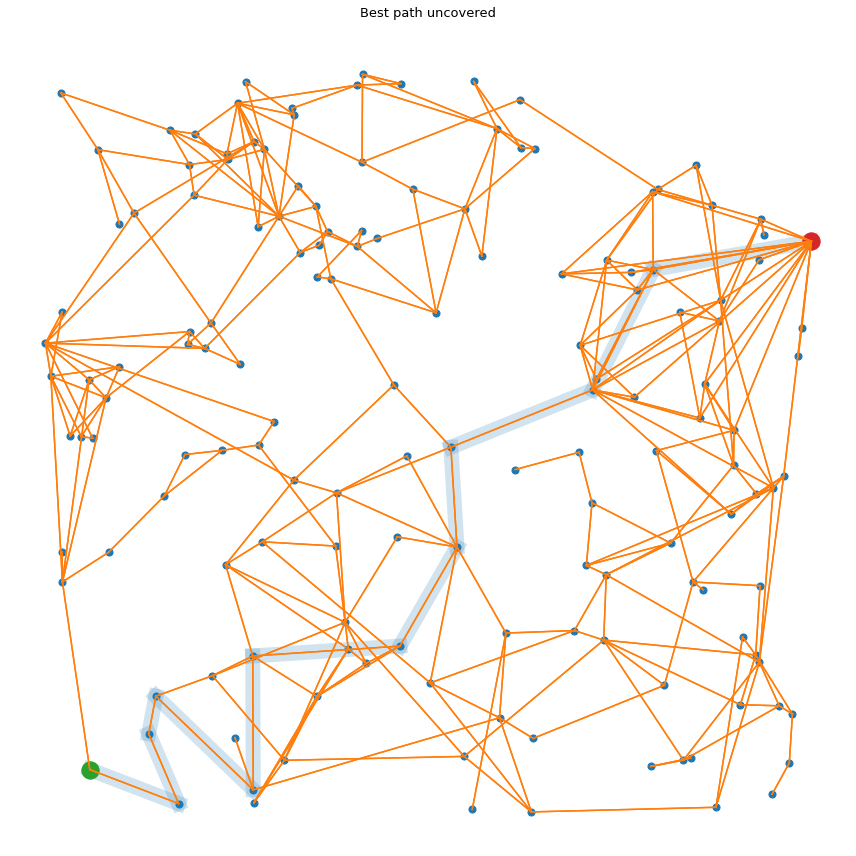

In [80]:
points = lattice

best_path = [source]
for i in range(N):
    best_path += [int(col_tensor[tf.argmax(tf.where(row_tensor == best_path[-1], proba, 0))])]
    if best_path[-1] == sink:
        break

plt.figure(figsize=(12, 12))

plt.title("Best path uncovered\n", fontsize=13)
for i, point in enumerate(points):
    s = 300 if i in [source, sink] else 50
    c = ('tab:green' if i == source else 'tab:red') if i in [source, sink] else 'tab:blue'
    plt.scatter(point[0], point[1], c=c, s=s)

for i, j in zip(row, col):
    plt.plot([points[i][0], points[j][0]], [points[i][1], points[j][1]], c='tab:orange')

for i, j in zip(best_path[:-1], best_path[1:]):
    plt.plot([points[i][0], points[j][0]], [points[i][1], points[j][1]], c='tab:blue', lw=15, zorder=-2, alpha=0.2)

plt.axis('off')
plt.tight_layout()
plt.show()

In [81]:
start_time = timeit.default_timer()

with tf.device('cpu:0'):
    proba, stats = gpu_run(row_tensor, col_tensor, hashes, tau, epochs=5000, s_mod=5)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

Time 9.0653s


In [85]:
start_time = timeit.default_timer()

with tf.device('gpu:0'):
    proba, stats = gpu_run(row_tensor, col_tensor, hashes, tau, epochs=5000, s_mod=5)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

Time 12.0171s


# With XLA compilation

In [86]:
@tf.function(reduce_retracing=True, jit_compile=True)
def gpu_run(row, col, hashes, tau, epochs, N=N, M=M, s_mod=1):
    with tf.GradientTape() as t:
        with t.stop_recording():
            ants = tf.zeros([M], dtype=tf.int32)
            starts = tf.zeros_like(ants, dtype=tf.int32)
            stats = tf.zeros([epochs], dtype=tf.int32)

            history = tf.zeros([h_len, M], dtype=tf.int32)
            history = tf.tensor_scatter_nd_update(history, tf.transpose(tf.stack([tf.fill([M], 0), tf.range(M)])), ants)

            eta = tf.ones_like(row, dtype=tf.float32)

            proba = tau * eta
            proba = proba / tf.gather(
                tf.math.reduce_sum(
                    tf.cast(row == tf.reshape(tf.range(N), [-1, 1]), dtype=tf.float32) * proba[tf.newaxis, :], axis=-1),
                row)

            step = tf.constant(0, dtype=tf.int32)
            while tf.less(step, epochs):
                proba, ants, history, starts, s = proceed_one_epoch(row, col, hashes, ants, history, proba, starts, step % h_len, sink, source, h_len, N, M, step, s_mod)
                stats = tf.tensor_scatter_nd_update(stats, [[step]], [s])
                step += 1
            
            return proba, stats

In [89]:
start_time = timeit.default_timer()

with tf.device('gpu:0'):
    proba, stats = gpu_run(row_tensor, col_tensor, hashes, tau, epochs=5000, s_mod=5)

end_time = timeit.default_timer()
print(f"Time {end_time - start_time :.4f}s")

Time 1.6399s


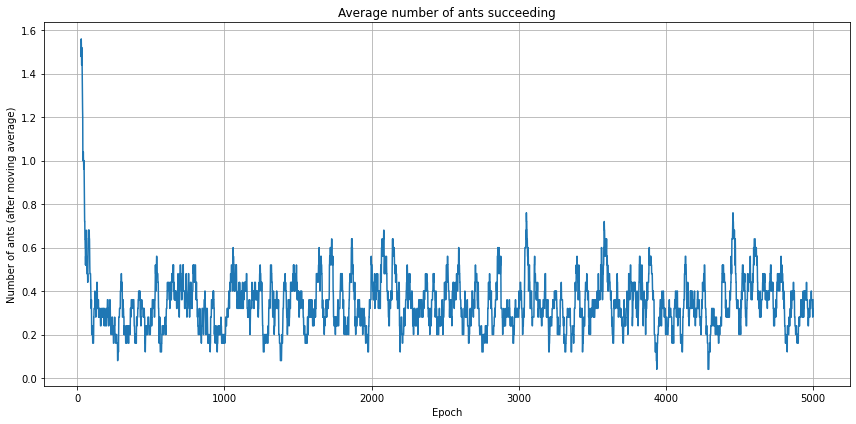

In [91]:
plt.figure(figsize=(12, 6))

ma = 25
cumusum = np.cumsum(stats)
avg_number_of_successful_ants = (cumusum[ma:] - cumusum[:-ma]) / ma
plt.title("Average number of ants succeeding")
plt.xlabel("Epoch")
plt.ylabel("Number of ants (after moving average)")
plt.plot(np.arange(ma, len(stats)), avg_number_of_successful_ants)
plt.grid()
plt.tight_layout()
plt.show()

In [3]:
@tf.function(reduce_retracing=True, jit_compile=True)
def xd(state):
    return tf.random.stateless_uniform([5], [state, -state])


with tf.device('gpu:0'):
    x1 = xd(5)
    x2 = xd(6)

print(x1)
print(x2)

tf.Tensor([0.17770183 0.41892493 0.76513696 0.14603376 0.96036136], shape=(5,), dtype=float32)
tf.Tensor([0.49123776 0.57455075 0.97768724 0.98570824 0.5340444 ], shape=(5,), dtype=float32)


Why does it break?